# SmoLAgents Framework Tutorial
This notebook provides a comprehensive introduction to SmoLAgents, a lightweight framework for building AI agents. It's particularly well-suited for prototyping and educational purposes. However, it might not be suitable for production grade.

## Agent Types
1. CodeAgent:
    - Approach: Generates and executes Python code
    - Strengths: Complex logic, variable handling, loops
    - Use case: Multi-step reasoning, data analysis
2. ToolCalling Agent:
    - Approach: Generates JSON for direct tool calls
    - Strengths: Simple, predictable, fast
    - Use case: Single-step operations, API calls

In [ ]:
from smolagents import CodeAgent, tool, InferenceClientModel
import os
from dotenv import load_dotenv
load_dotenv()

In [ ]:
# LLM model
model_id = 'Qwen/Qwen3-4B-Instruct-2507'
model = InferenceClientModel(
    max_tokens = 2096,
    model_id = model_id,
)

In [ ]:
# simply use the model to generate response, not an agent here (the tools are empty)
agent = CodeAgent(model= model, tools = [])
result = agent.run("I need your help.")

In [ ]:
# define tools
@tool
def my_custom_tool (arg:str) -> str:
    """A dummy tool that does nothing
    Args:
        arg: dummy arg
    """
    return "Here is your magic tool that does nothing. "

# CodeAgent
The CodeAgent assumes complex tasks might require multiple steps of reasoning and code execution:

1. Step 1: Analyze the problem and write initial code
2. Step 2: Examine results and decide if more work is needed
3. Step 3: Write additional code if necessary
4. Continue: Until the task is "complete"

In [ ]:
# Agent with dummy tool
from smolagents.agents import EMPTY_PROMPT_TEMPLATES
prompt_templates = EMPTY_PROMPT_TEMPLATES.copy()

prompt_templates['system_prompt'] = """
        You are an assistant with access to a special tool called `my_custom_tool`.
        Whenever the user asks to "see magic", "show magic", "do magic", or otherwise refers
        to something magical, you MUST call `my_custom_tool` with the user’s provided phrase
        as the `arg` argument. 

        Format your reasoning as follows:
        
        Thoughts: I need to call the magic tool.
        <code>
        # Your python code here
        my_custom_tool(arg="the magic tool")
        </code>
        Observation: "Here is your magic tool that does nothing. "
        
        - If the user does not provide an argument, pass "magic" as the default.
        - Do not try to answer the request directly when it involves magic—always use the tool.
        - After calling the tool, return its output to the user.
        - For all other requests not related to magic, just answer normally without calling the tool.
        """ 

agent_dummy = CodeAgent(
    model= model, 
    tools = [my_custom_tool],
    prompt_templates = prompt_templates,
    max_steps = 1
)
result = agent_dummy.run("Show me some magic!")

# ToolCallingAgents

Let’s look at an example. 

A CodeAgent would generate and run Python code like this:
```
for query in [
    "Best catering services in Gotham City", 
    "Party theme ideas for superheroes"
]:
    print(web_search(f"Search for: {query}"))
```

A ToolCallingAgent would instead create a JSON structure:
```
[
    {"name": "web_search", "arguments": "Best catering services in Gotham City"},
    {"name": "web_search", "arguments": "Party theme ideas for superheroes"}
]
```
This JSON blob is then used to execute the tool calls.

While smolagents primarily focuses on CodeAgents since they perform better overall, ToolCallingAgents can be effective for simple systems that don’t require variable handling or complex tool calls.

In [ ]:
from smolagents import ToolCallingAgent
prompt_templates1 = EMPTY_PROMPT_TEMPLATES.copy()
prompt_templates1['system_prompt'] = """
        You are an assistant with access to a special tool called `my_custom_tool`.
        Whenever the user asks to "see magic", "show magic", "do magic", or otherwise refers
        to something magical, you MUST call `my_custom_tool` with the user’s provided phrase
        as the `arg` argument. 
        
        Thoughts: I need to call the magic tool.
        Action: {"name": "my_custom_tool", "arguments": "magic"}
        Observation: "Here is your magic tool that does nothing. "
        
        - If the user does not provide an argument, pass "magic" as the default.
        - Do not try to answer the request directly when it involves magic—always use the tool.
        - After calling the tool, return its output to the user.
        - For all other requests not related to magic, just answer normally without calling the tool.
        """ 
agent_dummy2 = ToolCallingAgent(
    model= InferenceClientModel(), 
    tools = [my_custom_tool],
    prompt_templates = prompt_templates1,
    max_steps = 1
)
result2 = agent_dummy2.run("Show me some magic!")

In [ ]:
from datetime import datetime
import time

@tool
def get_time()->str:
    """A tool that fetches the current local time."""
    try:
        now = datetime.now()
        return f"🕒 It's {now.strftime('%I:%M %p')} on {now.strftime('%A, %B %d')}"
    except Exception as e:
        return f"❌ Error getting time: {str(e)}"
        
    
    

## FinalAnswerTool
You may notice that an agent seems to loop until the step limit is reached. This is because the agent has no clean way to terminate.

In smolagents, the FinalAnswerTool is a special built-in tool that lets an agent end its reasoning loop and return the final answer to the user. Think of it as the "exit door" for the agent:

During a reasoning chain, the agent might call tools, write Python, or fetch external info.
Once it has the actual result it wants to deliver, it must call FinalAnswerTool with that answer.
This prevents the agent from looping forever and makes it explicit: “I’m done, here’s the output.”
Why it matters

Without FinalAnswerTool, the agent might just keep reasoning and calling tools until it hits max_steps. By calling FinalAnswerTool, it signals to the framework that it has produced the answer for the user.

In [ ]:
from smolagents import FinalAnswerTool
final_answer = FinalAnswerTool()
prompt_templates2 = EMPTY_PROMPT_TEMPLATES.copy()

prompt_templates2['system_prompt'] = """
    You are an assistant agent. 
    You have access to the following tools:
    
    1. get_time -> Fetches and returns the current local time in a human-friendly format.
    2. final_answer -> Used to return your final response to the user.

    Here is an example:
    Task: What time is it?
    Thoughts: I need to call the get_time tool. After retriving the time, I need to call the final_answer tool to return the results.
    <code>
    get_time()
    final_answer()
    </code>
    
    Guidelines:
    - If a tool is needed, call it directly. Do not guess values you could fetch from tools.
    - After using tools and gathering results, provide the final reply to the user using final_answer.
    - Keep answers concise and clear.
    - Never expose tool call syntax to the user, only the results.

    """

agent_time = CodeAgent(
    model= model, 
    tools = [get_time, final_answer],
    max_steps = 2,
    verbosity_level = 2,
    prompt_templates = prompt_templates2
    
)
result = agent_time.run("What time?")

## verbosity_level
The parameter verbosity_level controls how much the agent logs or “thinks out loud” during its reasoning and tool use.

- verbosity_level=0 → Silent/minimal logging: 
    Only the final result is returned. No intermediate reasoning, tool calls, or debug info shown.

- verbosity_level=1 → Normal / concise logging (default):
    Prints the agent’s steps (like Thoughts: ..., tool calls, and observations), but in a summarized way. Good balance if you want to see what’s happening without too much clutter.

- verbosity_level=2 → Verbose / full trace
    Shows detailed chain-of-thought (well, the structured reasoning it’s allowed to show), intermediate code snippets, tool arguments, and outputs. Useful for debugging or when developing custom tools.

## Built-in Tools
Here is the link of smolagents built-in tools, if you are intersted.

https://huggingface.co/docs/smolagents/reference/default_tools

# Observability
- Monitor with Langfuse for insights
- Track tool usage patterns
- Analyze failure modes
- Optimize based on performance data


In [ ]:
# Get keys for your project from the project settings page: https://cloud.langfuse.com
from langfuse import get_client
from langfuse import Langfuse

LANGFUSE_SECRET_KEY=os.getenv("LANGFUSE_SECRET_KEY"),
LANGFUSE_PUBLIC_KEY=os.getenv("LANGFUSE_PUBLIC_KEY"),
LANGFUSE_HOST=os.getenv("LANGFUSE_HOST")


In [ ]:
# Verify connection
langfuse = get_client()
if langfuse.auth_check():
    print("Langfuse client is authenticated and ready!")
else:
    print("Authentication failed. Please check your credentials and host.")

In [ ]:
from openinference.instrumentation.smolagents import SmolagentsInstrumentor

SmolagentsInstrumentor().instrument()


In [ ]:
query = "How can I know the time?"
result = agent_time.run(query)

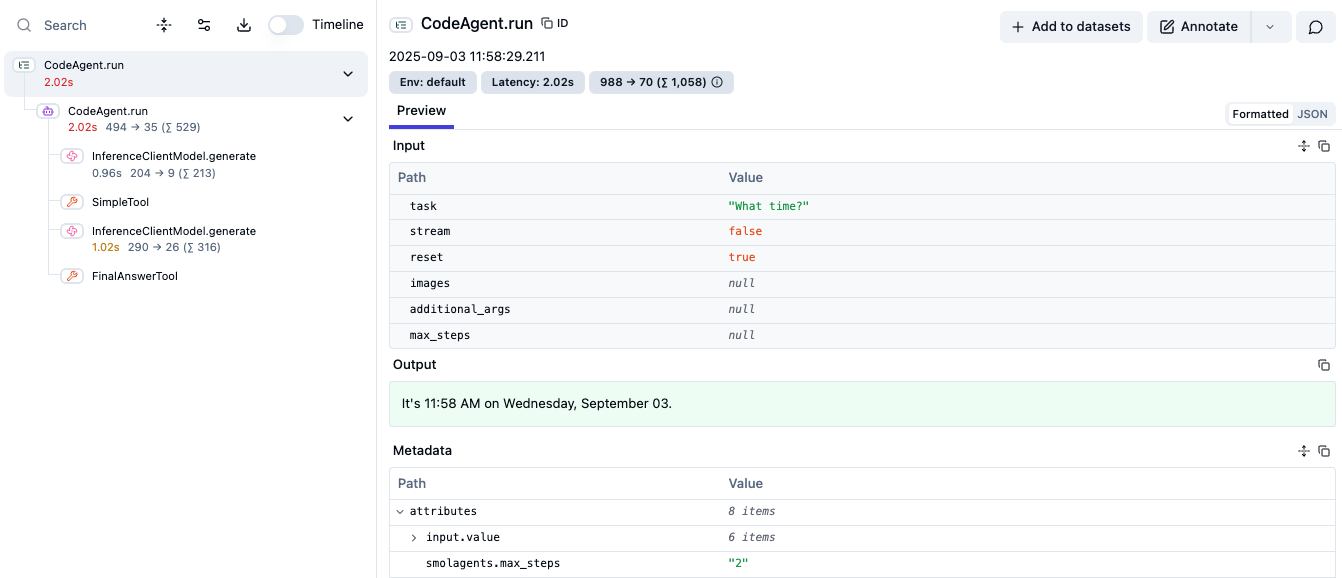